# 2nd Level Model Structure: Reactive Stage

In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from pyomo import environ as pe
from global_sets.component import m
from utility.display_utility import trans_product_mole, trans_product_mass
from utility.model_utility import add_dual, update_dual, check_DOF

# stage construction rules
from physics.kinetics.kinetics_reactive import kinetic_block_rule
from physics.energy.energy_reactive import energy_block_rule
from physics.VLE.VLE_reactive_MPCC_P import VLE_block_rule
from physics.MPCC.MPCC_P import P_NCP_block_rule, P_Reg_block_rule, P_pf_block_rule

model = pe.ConcreteModel()

# Global Sets (Inlet / Outlet)

In [3]:
model.inlet = pe.Set(initialize=['in'])
model.outlet = pe.Set(initialize=['out','P'])
model.stream = model.inlet | model.outlet

# Global Variables

In [4]:
# Tray Inlet/Outlet Variable
model.x_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.x = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.z = pe.Var(m.COMP_FEED,within=pe.NonNegativeReals)

model.L = pe.Var(model.stream,within=pe.NonNegativeReals)
model.V = pe.Var(model.stream,within=pe.NonNegativeReals)
model.F = pe.Var(within=pe.NonNegativeReals)

model.H_L_ = pe.Var(model.inlet,within=pe.Reals)
model.H_V_ = pe.Var(model.inlet,within=pe.Reals)
model.H_L = pe.Var(within=pe.Reals)
model.H_V = pe.Var(within=pe.Reals)
model.H_F = pe.Var(within=pe.Reals)

# State Variable
model.T = pe.Var(within=pe.NonNegativeReals,bounds=(100+273.15,350+273.15)) # K
model.T_F = pe.Var(within=pe.NonNegativeReals) # K
model.P = pe.Var(within=pe.NonNegativeReals,bounds=(10,30)) # Bar

model.f_V = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)
model.f_L = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)

model.cat = pe.Var(within=pe.NonNegativeReals,initialize=3000) # kg
model.Q_main = pe.Var(within=pe.Reals) # MW
model.r_total_comp = pe.Var(m.COMP_TOTAL,within=pe.Reals) # kmol/s

# Construct Individual Blocks

In [5]:
model.kinetics_block = pe.Block(rule=kinetic_block_rule)

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| kinetics_block.k_FT
| kinetics_block.r_FT_total
| kinetics_block.g0_FT
| kinetics_block.alpha
| kinetics_block.r_FT_cnum
| kinetics_block.r_FT_comp
| kinetics_block.k_WGS
| kinetics_block.Ke_WGS
| kinetics_block.r_WGS
| kinetics_block.r_WGS_comp
--------------------------------------------------



In [6]:
model.energy_block = pe.Block(rule=energy_block_rule)

> Importing Energy Blocks......
> Adding the following local variable:
--------------------------------------------------
| energy_block.dH_F
| energy_block.dH_V
| energy_block.dH_L
| energy_block.dH_vap
--------------------------------------------------



In [7]:
model.VLE_block = pe.Block(rule=VLE_block_rule)

> Importing VLE Blocks......
> Adding the following local variable:
--------------------------------------------------
| VLE_block.P_VLE
| VLE_block.n_ave
| VLE_block.n_ave_cal
| VLE_block.Hen
| VLE_block.Hen0
| VLE_block.gamma
| VLE_block.P_sat
| VLE_block.P_sat_Y
| VLE_block.P_sat_dY_inf
| VLE_block.P_sat_dY0
| VLE_block.Hen_ref
| VLE_block.Hen0_ref
| VLE_block.gamma_ref
| VLE_block.V_L
| VLE_block.V_L_dY_inf
| VLE_block.V_L_dY0
| VLE_block.poynting
--------------------------------------------------



# Standard MESH Equations

## Mass Balance

\begin{equation}
Fz_{i}+\sum_{s\in{inlet}}L_{s}x'_{i,s}+\sum_{s\in{inlet}}V_{s}y'_{i,s}-\sum_{s\in{outlet}}L_{s}x_{i,s}+\sum_{s\in{ouelet}}V_{s}y_{i,s}+R_{i} = 0 \\
i = 1,...NC
\end{equation}

In [8]:
def mass_balance_main_rule(model,i):
    if i in m.COMP_FEED:
        return model.F*model.z[i] + sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
    else:
        return sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
model.mass_balance_main_con = pe.Constraint(m.COMP_TOTAL,rule=mass_balance_main_rule)

## Equilibrium

\begin{align}
&f_{i,V} = f_{i,L} \\
&i = 1,...NC
\end{align}

In [9]:
def VL_equil_rule(model,i):
    return model.f_V[i] == model.f_L[i]
model.VL_equil_con = pe.Constraint(m.COMP_TOTAL,rule=VL_equil_rule)

## MPCC: P-Pspec

In [10]:
model.MPCC = pe.Block(rule = P_pf_block_rule)

> Importing MPCC_P_pf Blocks......
> Adding the following local variable:
--------------------------------------------------
| MPCC.s_L
| MPCC.s_V
| MPCC.pf
| MPCC.rho
| MPCC.epi
--------------------------------------------------
> Spliting pressure used in VLE



## Summation

\begin{equation}
\sum_ix_{i} = \sum_iy_{i} \\
F + L_{in} + V_{in} + R = L_{out} + V_{out}
\end{equation}

In [11]:
def summation_x_y_rule(model):
    return sum(model.x[i] for i in m.COMP_TOTAL) == sum(model.y[i] for i in m.COMP_TOTAL)
model.summation_x_y_con = pe.Constraint(rule=summation_x_y_rule)

def summation_total_mass_rule(model):
    return model.F + sum(model.L[s] + model.V[s] for s in model.inlet) + sum(model.r_total_comp[i] for i in m.COMP_TOTAL)\
            - sum(model.L[s] + model.V[s] for s in model.outlet) == 0
model.summation_total_mass_con = pe.Constraint(rule=summation_total_mass_rule)

## Energy Balance

\begin{equation}
F H_f+\sum_{s\in{inlet}}L_{s}H_{l,s}+\sum_{s\in{inlet}}V_{s}H_{v,s}-\sum_{s\in{outlet}}L_{s}H_{l,s}-\sum_{s\in{outlet}}V_{s}H_{v,s}+Q = 0
\end{equation}

In [12]:
def heat_balance_main_rule(model):
    return model.F*model.H_F + sum(model.L[s]*model.H_L_[s] + model.V[s]*model.H_V_[s] for s in model.inlet) \
            + model.Q_main - sum(model.L[s]*model.H_L + model.V[s]*model.H_V for s in model.outlet) == 0
model.heat_balance_main_con = pe.Constraint(rule=heat_balance_main_rule)

# Testing

In [13]:
add_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


## Fixing In/Product Redundent Flow

In [14]:
model.x_.fix(0)
model.y_.fix(0)
model.L['in'].fix(0)
model.L['P'].fix(0)
model.V['in'].fix(0)
model.V['P'].fix(0)
model.H_L_.fix(0)
model.H_V_.fix(0)

## Fixing Model Parameters

In [15]:
model.cat.fix(3000)
model.P.fix(20)
model.T_F.fix(200+273.15)
model.F.fix(1)
model.z['CO'].fix(1/(1+0.8)-0.01/2)
model.z['H2'].fix(0.8/(1+0.8)-0.01/2)
model.z['C30H62'].fix(0.01)
model.VLE_block.n_ave.fix(20)

In [16]:
check_DOF(pe,model)

Active Equality Constraints:	 1182
Active Inequality Constraints:	 1
Active Variables:		 1358
Fixed Variables:		 172
DOF:				 4


## Fix T or to fix Q? we have found that Maximize against an upper bound is most reliable

In [17]:
model.T.setub(200+273.15)

In [18]:
# model.obj = pe.Objective(expr = model.L['out'],sense=pe.maximize)
# model.obj = pe.Objective(expr = model.cat,sense=pe.minimize)
# model.obj = pe.Objective(expr = model.T - model.MPCC.pf ,sense=pe.maximize)
model.obj = pe.Objective(expr = model.T - model.MPCC.pf ,sense=pe.maximize)

In [19]:
opt = pe.SolverFactory('ipopt')

opt.options['print_user_options'] = 'yes'
# opt.options['linear_solver'] = 'ma86'

# opt.options['linear_system_scaling '] = 'mc19'
opt.options['linear_scaling_on_demand '] = 'no'
# opt.options['recalc_y'] = 'yes'
# opt.options['bound_relax_factor'] = 0
# opt.options['halt_on_ampl_error'] = 'yes'

opt.options['max_iter'] = 7000
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.11.1: print_user_options=yes
linear_scaling_on_demand =no
max_iter=7000


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                     no
                                max_iter = 7000                  yes
                      print_user_options = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonze

Constraint violation....:  2.2737367544323206e-013   2.2737367544323206e-013
Complementarity.........:  9.1924977302508668e-010   9.1924977302508668e-010
Overall NLP error.......:  9.1924977302508668e-010   9.1924977302508668e-010


Number of objective function evaluations             = 132
Number of objective gradient evaluations             = 58
Number of equality constraint evaluations            = 132
Number of inequality constraint evaluations          = 132
Number of equality constraint Jacobian evaluations   = 86
Number of inequality constraint Jacobian evaluations = 86
Number of Lagrangian Hessian evaluations             = 77
Total CPU secs in IPOPT (w/o function evaluations)   =      0.528
Total CPU secs in NLP function evaluations           =      0.044

EXIT: Optimal Solution Found.


In [20]:
model.T.value

473.15

In [21]:
model.MPCC.s_L.value

8.359347843252524e-08

In [22]:
model.VLE_block.P_VLE.value

20.000000090092968

In [23]:
model.L['out'].value

0.01974038344875429

In [24]:
print('Component\t\tLiquid: {:.4f}\t\t\tVapor: {:.4f}'.format(model.L['out'].value,model.V['out'].value))
print('-'*108)
for i in model.x:
    print('{:10s}'.format(i),'\t\t{:8.4%}\t\t\t{:8.4%}'.format(model.x[i].value,model.y[i].value))

Component		Liquid: 0.0197			Vapor: 0.5187
------------------------------------------------------------------------------------------------------------
H2         		 0.8750%			25.0416%
CO         		 1.3345%			28.5738%
CO2        		 3.7740%			32.2862%
H2O        		 3.6365%			12.5211%
C2H4       		 0.0176%			 0.1188%
C3H6       		 0.0448%			 0.1363%
C4H8       		 0.0459%			 0.1213%
C5H10      		 0.0720%			 0.0929%
C6H12      		 0.1240%			 0.0850%
C7H14      		 0.1993%			 0.0766%
C8H16      		 0.3016%			 0.0675%
C9H18      		 0.4310%			 0.0577%
C10H20     		 0.5802%			 0.0475%
C11H22     		 0.4681%			 0.0238%
C12H24     		 0.5575%			 0.0178%
C13H26     		 0.6275%			 0.0128%
C14H28     		 0.6729%			 0.0088%
C15H30     		 0.6941%			 0.0058%
C16H32     		 0.6954%			 0.0038%
C17H34     		 0.6823%			 0.0024%
C18H36     		 0.6597%			 0.0016%
C19H38     		 0.6316%			 0.0010%
C20H40     		 0.6007%			 0.0006%
C1H4       		 0.0166%			 0.1952%
C2H6       		 0.0108%			 0.0638%
C3H8       		 0.0115%			

In [25]:
# model.solutions.store_to(results)
# with open('../saved_solutions/reactive_flash_MPCC_P_pf_200C.pickle','wb') as f:
#     pickle.dump(results,f)

# Iterative Solve for Data Analysis

In [26]:
results_anchor = results
update_dual(pe,model)
model.solutions.store_to(results_anchor)

In [27]:
opt.options['warm_start_init_point'] = 'yes'
opt.options['warm_start_bound_push'] = 1e-20
opt.options['warm_start_mult_bound_push'] = 1e-20
opt.options['mu_init'] = 1e-6

In [28]:
rf_data = {}
rf_data['r'] = {}; rf_data['T'] = []; rf_data['Q'] = []; rf_data['V'] = []; rf_data['L'] = []; 
rf_data['y_CO'] = []; rf_data['y_H2'] = []; rf_data['y_CO2'] = []; rf_data['y_H2O'] = []; rf_data['r_WGS'] = []; rf_data['r_FT'] = []
rf_data['f_V_CO'] = []; rf_data['f_V_H2'] = [];

for i in model.r_total_comp:
    rf_data['r'][i] = []
    
Trange = np.arange(200+273.15,301+273.15,1)

for Tub in Trange:
    model.T.setub(Tub)
    results = opt.solve(model,tee=False)
    update_dual(pe,model)
    # print('-'*72)
    print('Solved, Solution T = {:.2f} K\t|\tV = {:.5f}\t|\tL = {:.5f}\t|'.format(model.T.value,model.V['out'].value,model.L['out'].value))
    # print('-'*72)
    rf_data['T'].append(model.T.value)
    rf_data['Q'].append(model.Q_main.value)
    rf_data['V'].append(model.V['out'].value)
    rf_data['L'].append(model.L['out'].value)    

    for i in model.r_total_comp:
        rf_data['r'][i].append(model.r_total_comp[i].value)
    
    
    rf_data['y_H2O'].append(model.y['H2O'].value)
    rf_data['y_CO'].append(model.y['CO'].value)
    rf_data['y_H2'].append(model.y['H2'].value)
    rf_data['y_CO2'].append(model.y['CO2'].value)
    rf_data['r_WGS'].append(model.kinetics_block.r_WGS.value)
    rf_data['r_FT'].append(model.kinetics_block.r_FT_total.value)
    
    rf_data['f_V_CO'].append(model.f_V['CO'].value)
    rf_data['f_V_H2'].append(model.f_V['H2'].value)

Solved, Solution T = 473.15 K	|	V = 0.51869	|	L = 0.01974	|
Solved, Solution T = 474.15 K	|	V = 0.50793	|	L = 0.02003	|
Solved, Solution T = 475.15 K	|	V = 0.49764	|	L = 0.02030	|
Solved, Solution T = 476.15 K	|	V = 0.48786	|	L = 0.02057	|
Solved, Solution T = 477.15 K	|	V = 0.47862	|	L = 0.02083	|
Solved, Solution T = 478.15 K	|	V = 0.46992	|	L = 0.02107	|
Solved, Solution T = 479.15 K	|	V = 0.46178	|	L = 0.02129	|
Solved, Solution T = 480.15 K	|	V = 0.45420	|	L = 0.02150	|
Solved, Solution T = 481.15 K	|	V = 0.44718	|	L = 0.02169	|
Solved, Solution T = 482.15 K	|	V = 0.44070	|	L = 0.02186	|
Solved, Solution T = 483.15 K	|	V = 0.43476	|	L = 0.02200	|
Solved, Solution T = 484.15 K	|	V = 0.42932	|	L = 0.02212	|
Solved, Solution T = 485.15 K	|	V = 0.42436	|	L = 0.02222	|
Solved, Solution T = 486.15 K	|	V = 0.41987	|	L = 0.02229	|
Solved, Solution T = 487.15 K	|	V = 0.41581	|	L = 0.02234	|
Solved, Solution T = 488.15 K	|	V = 0.41217	|	L = 0.02236	|
Solved, Solution T = 489.15 K	|	V = 0.40

# Some observations

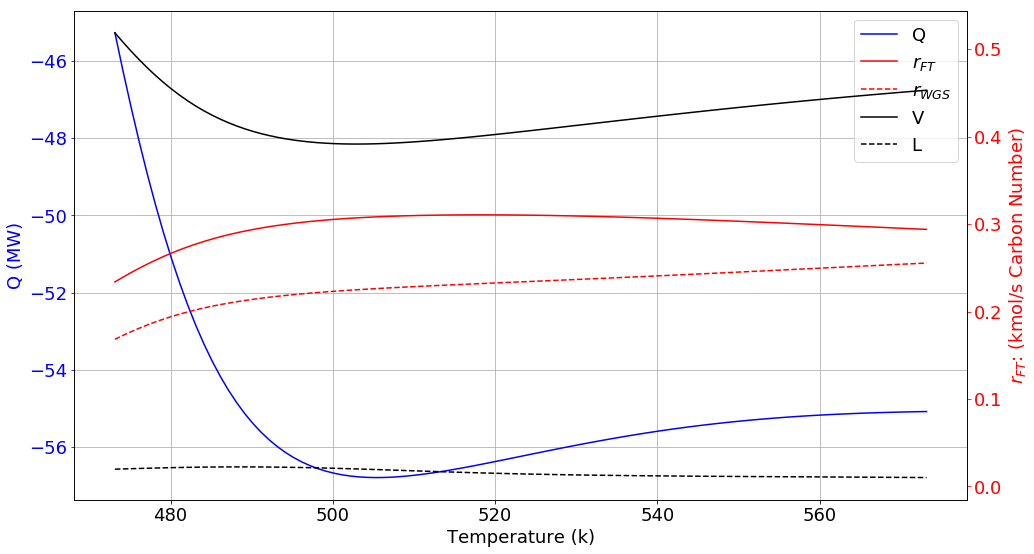

In [44]:
fig, ax1 = plt.subplots(figsize=(16,9))
line1 = ax1.plot(rf_data['T'],rf_data['Q'], 'b-')
ax1.set_xlabel('Temperature (k)', color='K',fontsize=18)
ax1.set_ylabel('Q (MW)', color='b',fontsize=18)
ax1.tick_params('y', colors='b',labelsize=18)
ax1.tick_params('x', colors='k',labelsize=18)
ax1.grid()

ax2 = ax1.twinx()
line2 = ax2.plot(rf_data['T'],rf_data['r_FT'], 'r')
line3 = ax2.plot(rf_data['T'],rf_data['r_WGS'], 'r--')
line4 = ax2.plot(rf_data['T'],rf_data['V'], 'k')
line5 = ax2.plot(rf_data['T'],rf_data['L'], 'k--')
ax2.set_ylabel('$r_{FT}$: (kmol/s Carbon Number)', color='r',fontsize=18)
ax2.tick_params('y', colors='r',labelsize=18)

ax1.legend(line1+line2+line3+line4+line5,['Q','$r_{FT}$','$r_{WGS}$','V','L'],fontsize=18,loc=1)
# ax1.set_title('Heat Removal Rate and Reaction Rate vs T',fontsize=18)
plt.show()

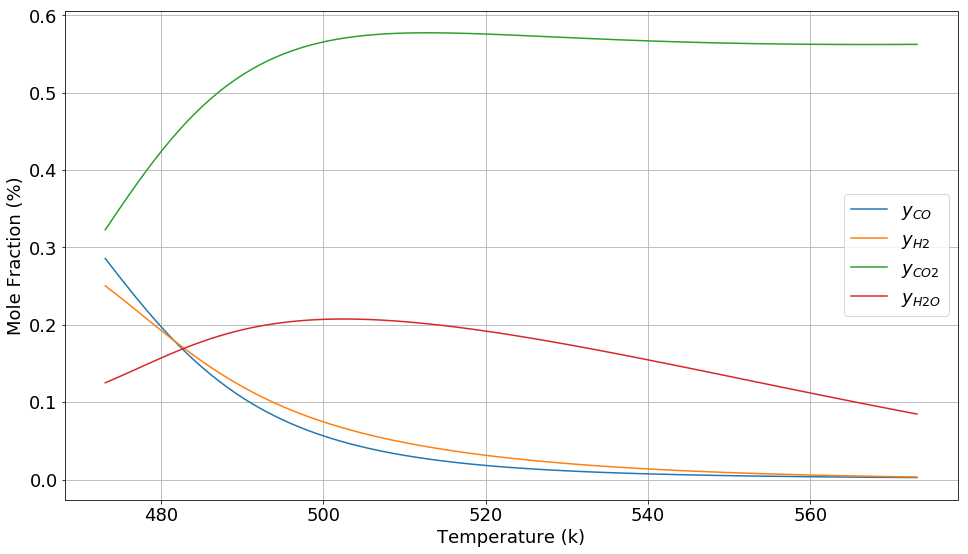

In [45]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['y_CO'])
ax.plot(rf_data['T'],rf_data['y_H2'])
ax.plot(rf_data['T'],rf_data['y_CO2'])
ax.plot(rf_data['T'],rf_data['y_H2O'])

ax.legend(['$y_{CO}$','$y_{H2}$','$y_{CO2}$','$y_{H2O}$'],fontsize=18)
# ax.set_title('Gas Phase Inorganic Composition vs T',fontsize=18)

ax.set_ylabel('Mole Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()
plt.show()

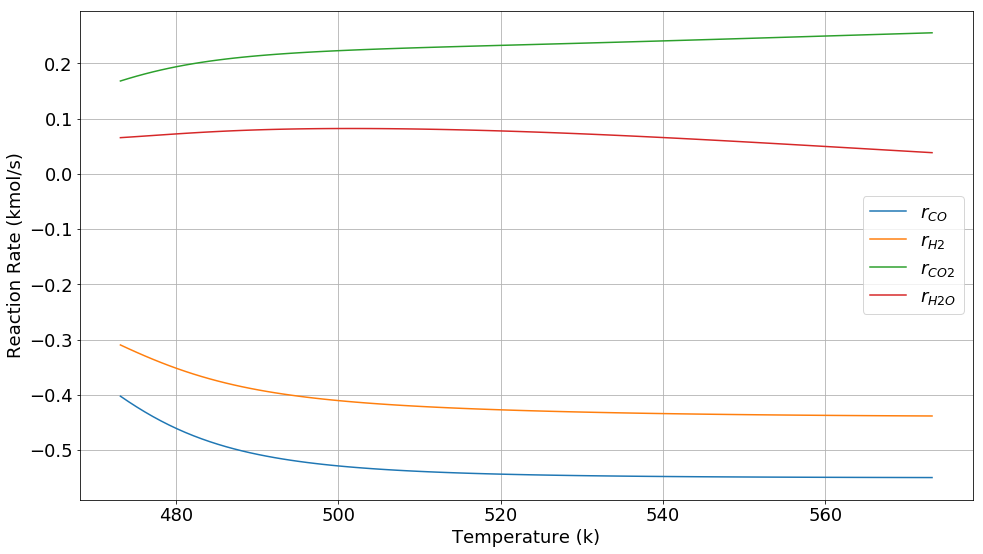

In [46]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['r']['CO'])
ax.plot(rf_data['T'],rf_data['r']['H2'])
ax.plot(rf_data['T'],rf_data['r']['CO2'])
ax.plot(rf_data['T'],rf_data['r']['H2O'])

ax.legend(['$r_{CO}$','$r_{H2}$','$r_{CO2}$','$r_{H2O}$'],fontsize=18)
# ax.set_title('Inorganic Reaction Rate vs T',fontsize=18)

ax.set_ylabel('Reaction Rate (kmol/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()
plt.show()

# Product Distribution (mole)

In [32]:
reaction_data = trans_product_mole(rf_data['r'])['unscaled']
reaction_data_scaled = trans_product_mole(rf_data['r'])['scaled']

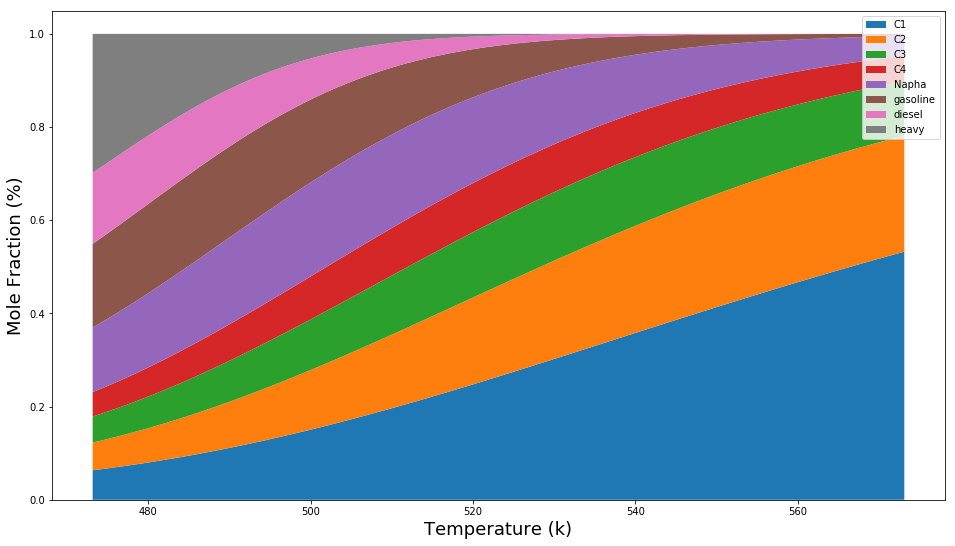

In [47]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], reaction_data_scaled['c1'], reaction_data_scaled['c2'],reaction_data_scaled['c3'],reaction_data_scaled['c4'],\
            reaction_data_scaled['napha'],reaction_data_scaled['gasoline'],reaction_data_scaled['diesel'],reaction_data_scaled['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
# ax.set_title('Product Composition (Mole) vs T',fontsize=18)
ax.set_ylabel('Mole Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

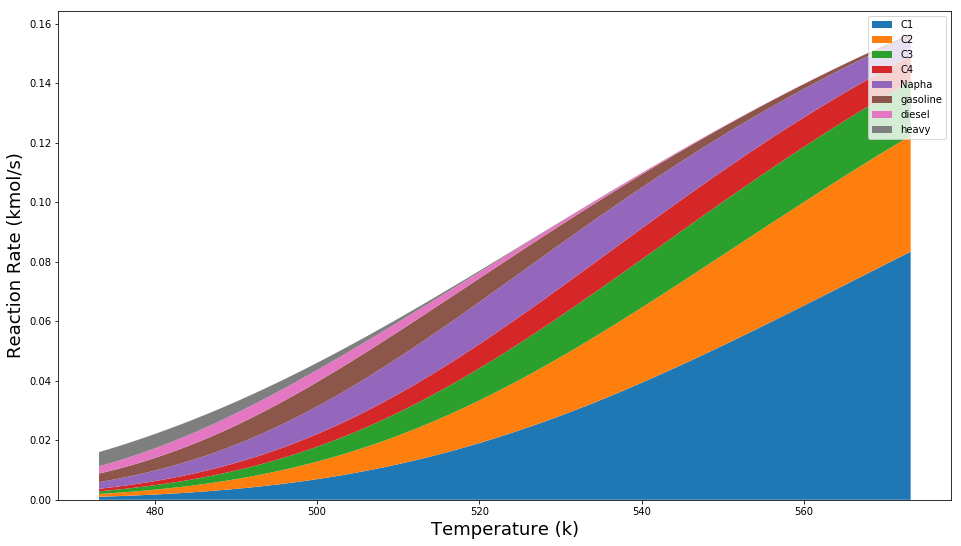

In [48]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], reaction_data['c1'], reaction_data['c2'],reaction_data['c3'],reaction_data['c4'],\
            reaction_data['napha'],reaction_data['gasoline'],reaction_data['diesel'],reaction_data['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
# ax.set_title('Total Production Rate (Mole) vs T',fontsize=18)
ax.set_ylabel('Reaction Rate (kmol/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

# Product Distribution (mass)

In [35]:
mass_reaction_data = trans_product_mass(rf_data['r'])['unscaled']
mass_reaction_scaled = trans_product_mass(rf_data['r'])['scaled']

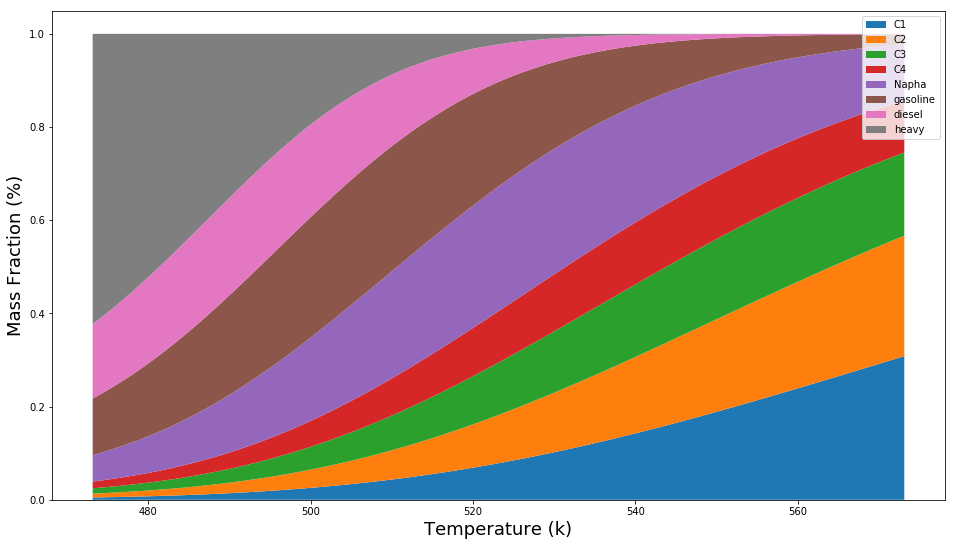

In [49]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], mass_reaction_scaled['c1'], mass_reaction_scaled['c2'],mass_reaction_scaled['c3'],mass_reaction_scaled['c4'],\
            mass_reaction_scaled['napha'],mass_reaction_scaled['gasoline'],mass_reaction_scaled['diesel'],mass_reaction_scaled['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
# ax.set_title('Product Composition (Mass) vs T',fontsize=18)
ax.set_ylabel('Mass Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

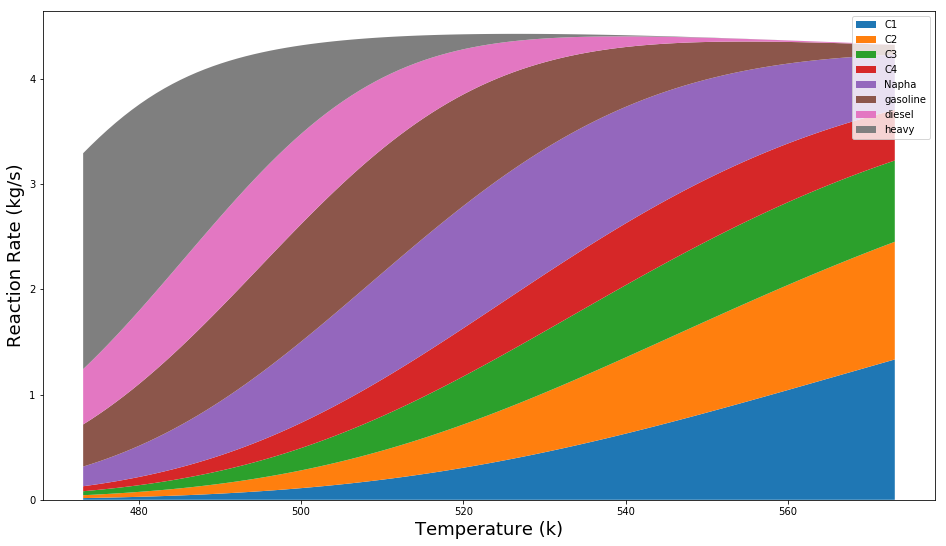

In [50]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], mass_reaction_data['c1'], mass_reaction_data['c2'],mass_reaction_data['c3'],mass_reaction_data['c4'],\
            mass_reaction_data['napha'],mass_reaction_data['gasoline'],mass_reaction_data['diesel'],mass_reaction_data['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
# ax.set_title('Total Production Rate (mass) vs T',fontsize=18)
ax.set_ylabel('Reaction Rate (kg/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()